In [1]:
# %load hubbard1d.py
"""
Test Lindblad based method for ground state preparation for spinful Hubbard
model.

Last revision: 05/24/2023
"""

from quspin.operators import hamiltonian
from quspin.basis import spinful_fermion_basis_1d
from quspin.tools.evolution import expm_multiply_parallel

import numpy as np # generic math functions
import scipy.linalg as la
import matplotlib.pyplot as plt
from qutip import Qobj, mesolve

from lindblad import Lindblad


if __name__ == "__main__":
    ##### define model parameters #####
    L=4 # system size
    J=1.0 # hopping
    U=4.0 # interaction
    mu=0.0 # chemical potential
    	
    # define boson basis with 3 states per site L bosons in the lattice
    N_up = L//2 + L % 2 # number of fermions with spin up
    N_down = L//2 # number of fermions with spin down
#    N_up = 1
#    N_down = L-1
    
    fermion_basis = spinful_fermion_basis_1d(L,Nf=(N_up,N_down))
    
    hop_right=[[-J,i,i+1] for i in range(L-1)] #open BC
    hop_left= [[+J,i,i+1] for i in range(L-1)] #open BC
    pot=[[-mu,i] for i in range(L)] # -\mu \sum_j n_{j \sigma}
    interact=[[U,i,i] for i in range(L)] # U/2 \sum_j n_{j,up} n_{j,down}
    # define static and dynamic lists
    static=[
            ['+-|',hop_left],  # up hops left
            ['-+|',hop_right], # up hops right
            ['|+-',hop_left],  # down hops left
            ['|-+',hop_right], # down hops right
            ['n|',pot],        # up on-site potention
            ['|n',pot],        # down on-site potention
            ['n|n',interact]   # up-down interaction
                                    ]
    dynamic=[]

    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    H=hamiltonian(static,dynamic,basis=fermion_basis,
            dtype=np.float64,**no_checks)

    # calculate spin energy levels
    E_GS,psi_GS = H.eigsh(k=1,which="SA")
    psi_GS = psi_GS.flatten()
    print('E_GS = ', E_GS)
    
    H_mat = np.array(H.todense())
    E_H , psi_H = la.eigh(H_mat)
    gap = E_H[1] - E_H[0]
    print('gap = ', gap)


    a = 2.5*la.norm(H_mat,2)
    da = 0.5*la.norm(H_mat,2)
    b = gap
    db = gap

    filter_params = {'a': a, 'b': b, 'da': da, 'db': db} 

#    A = hamiltonian([ ['n|n',[[1,0,0]]] ],[],basis=fermion_basis,
#            dtype=np.float64,**no_checks)
    J = 1.0
    A = hamiltonian([ ['+-|',[[J,0,1]]], ['-+|',[[-J,0,1]]], 
                      ['|+-',[[J,0,1]]], ['|-+',[[-J,0,1]]] ],[],basis=fermion_basis,
            dtype=np.float64,**no_checks)
#    A = hamiltonian([ ['n|',[[1,0]]], ['|n',[[-1,0]]] ],[],basis=fermion_basis,
#            dtype=np.float64,**no_checks)
    A_mat = np.array(A.todense())

    lb = Lindblad(H_mat, A_mat, filter_params)

    # fix the random seed
    np.random.seed(seed=1)
#    vt = np.random.randn(lb.Ns)
#    psi0 = vt / la.norm(vt)
#    psi0 = psi_GS.reshape(-1)
    

    # Noninteracting problem
    # define static and dynamic lists
    static_0=[
            ['+-|',hop_left],  # up hops left
            ['-+|',hop_right], # up hops right
            ['|+-',hop_left],  # down hops left
            ['|-+',hop_right], # down hops right
            ['n|',pot],        # up on-site potention
            ['|n',pot]         # down on-site potention
                                    ]
    H0=hamiltonian(static_0,dynamic,basis=fermion_basis,
            dtype=np.float64,**no_checks)

    H0_mat = np.array(H0.todense())
    E_H0, psi_H0 = la.eigh(H0_mat)
    psi0 = psi_H0[:,0]
    psi0 -= psi_GS * np.vdot(psi_GS,psi0)
    psi0 = psi0 / la.norm(psi0)

    print('|<psi0|psiGS>| = ', np.abs(np.vdot(psi_GS,psi0)))
    T = 100
    num_t = T
    T_kraus = 5 / db
    Nt_kraus = np.int(5/db/(2*np.pi/(4*a)))
    num_segment = 1
    num_rep = 100
    times = np.arange(num_t+1) * (T/num_t)

    H_obj = Qobj(H_mat)
    zero_obj = Qobj(np.zeros_like(H_mat))

    rho_GS_obj = Qobj(np.outer(psi_GS, psi_GS.conj()))

    mode = 'mesolve'
    lb.construct_kraus_coherent_freq()
    result = mesolve(H_obj, Qobj(psi0), times, [Qobj(lb.A_kraus)],
                [H_obj, rho_GS_obj])
    avg_H_e = result.expect[0]
    avg_pGS_e = result.expect[1]

E_GS =  [-1.95314531]
gap =  0.5402466127654701
|<psi0|psiGS>| =  1.1449174941446927e-16


/var/folders/0k/l2cqwppj67g8y4c4nt5v5q7w0000gn/T/ipykernel_17314/3882017935.py:116: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Nt_kraus = np.int(5/db/(2*np.pi/(4*a)))


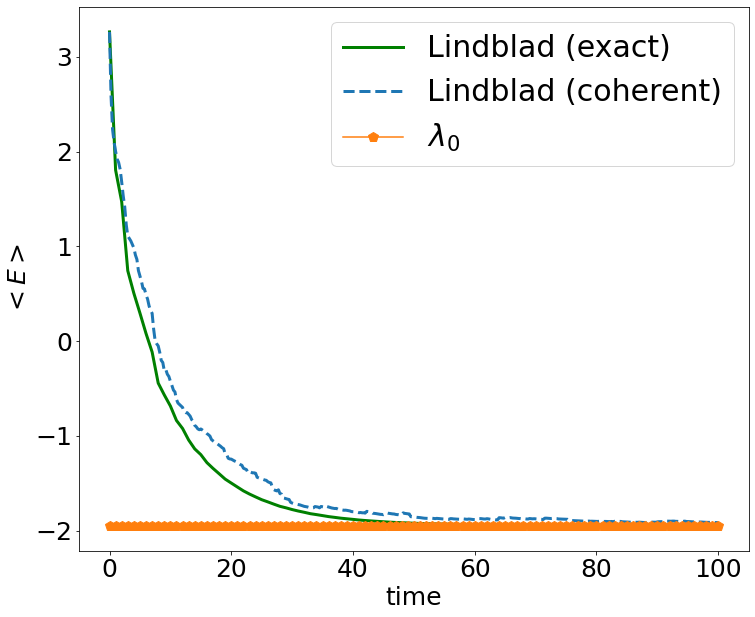

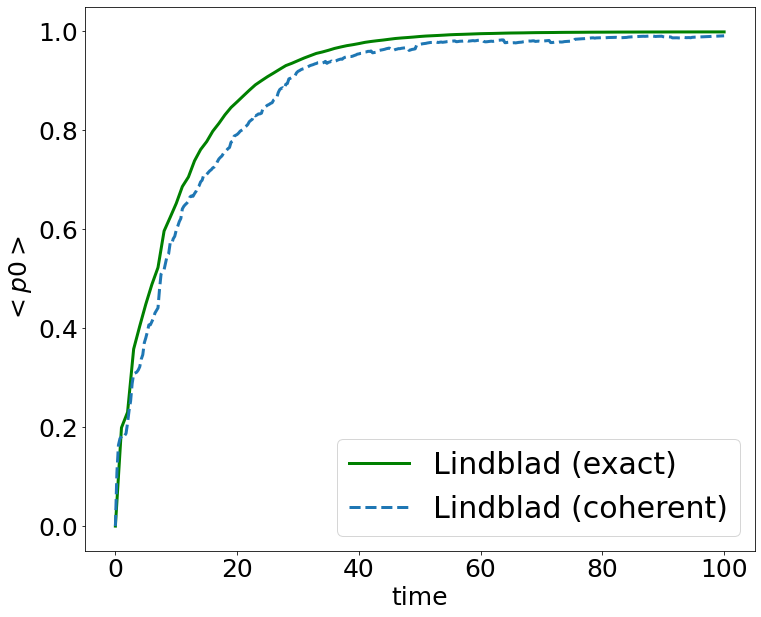

/var/folders/0k/l2cqwppj67g8y4c4nt5v5q7w0000gn/T/ipykernel_17314/3779435159.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x=np.linspace(-6/db,6/db, num=np.int(100/b))


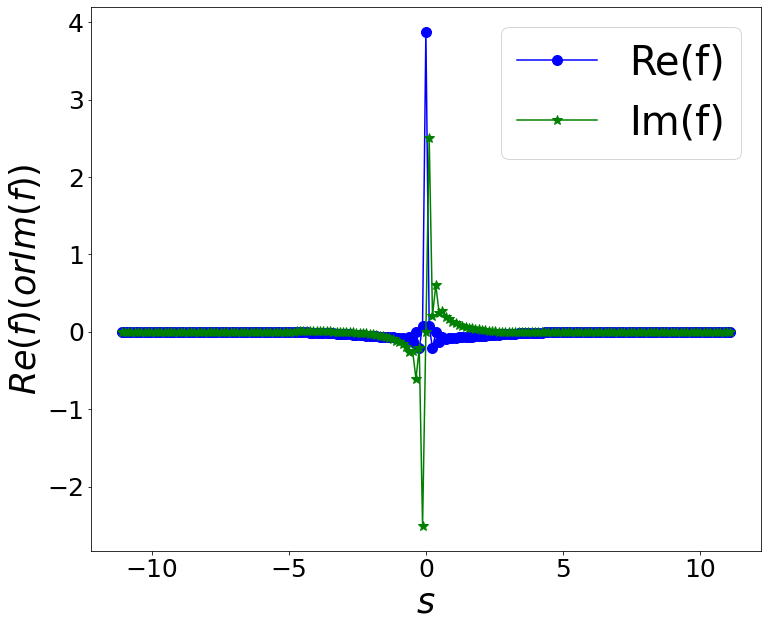

/Users/zhiyan_ding/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


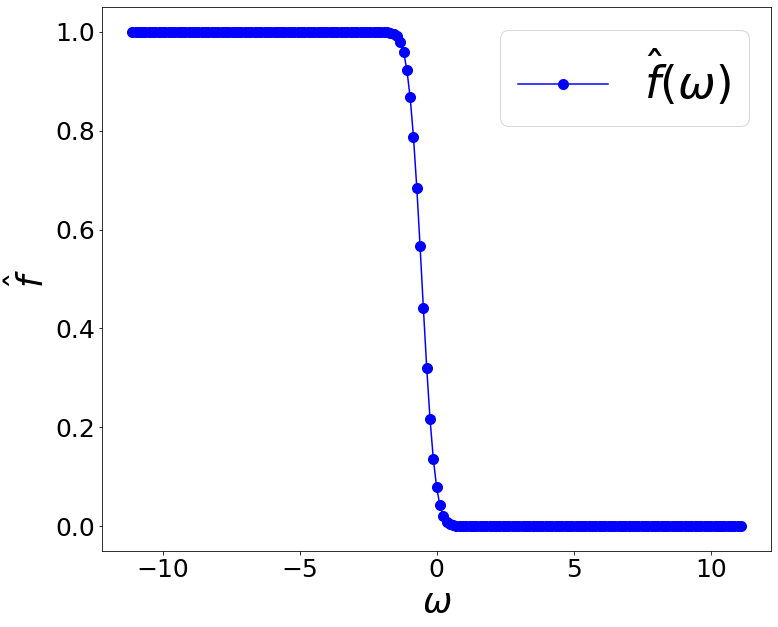

In [2]:
#coherent check
mode = 'coherent'
num_t = 4*int(T)
times_c, avg_H_c, avg_pGS_c, rho_all_c = lb.evolve_kraus_coherent(T, num_t, psi0, num_rep, psi_GS)
#continuous check
plt.figure(figsize=(12,10))
plt.plot(times, avg_H_e, 'g-', label='Lindblad (exact)', linewidth=3, markersize=10)
plt.plot(times_c, avg_H_c, '--', label='Lindblad (coherent)', linewidth=3, markersize=10)
plt.plot(times, np.ones_like(times)*E_GS, 'p-', label=r'$\lambda_0$', linewidth=1.5,markersize=10)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<E>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.show()

plt.figure(figsize=(12,10))
plt.plot(times, avg_pGS_e,'g-', label=r'Lindblad (exact)', linewidth=3, markersize=20)
plt.plot(times_c, avg_pGS_c,'--', label=r'Lindblad (coherent)', linewidth=3, markersize=20)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<p0>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30,loc="lower right")
plt.show()

#filter check
x=np.linspace(-6/db,6/db, num=np.int(100/b))
f=np.zeros(len(x),'complex')
hat_f_prefect=np.zeros(len(x),'complex')
for n in range(len(x)):
    f[n]=lb.filter_time(x[n])
    hat_f_prefect[n]=lb.filter_freq(x[n])
plt.figure(figsize=(12,10))
plt.plot(x,np.real(f), 'o-', color = "b", label='Re(f)', linewidth=1.5,markersize=10)
plt.plot(x,np.imag(f), '*-', color = "g", label='Im(f)', linewidth=1.5,markersize=10)
plt.xlabel('$s$',fontsize=35)
plt.ylabel('$Re(f)(or Im(f))$',fontsize=35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=40,loc='upper right')
plt.show()
plt.figure(figsize=(12,10))
plt.plot(x,hat_f_prefect,'o-', color = "b", label=r'$\hat{f}(\omega)$', linewidth=1.5,markersize=10)
plt.xlabel('$\omega$',fontsize=35)
plt.ylabel('$\hat{f}$',fontsize=35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=45,loc='upper right')
plt.show()

In [3]:
#discretize
mode = 'decoherent (large tau)'
num_segment=3
times_l, avg_H_l, avg_pGS_l, time_H_l, rho_all_l = lb.evolve_kraus_decoherent_batch(T, num_t,
        num_segment, psi0, num_rep, T_kraus, Nt_kraus,
        psi_GS, intorder=2)

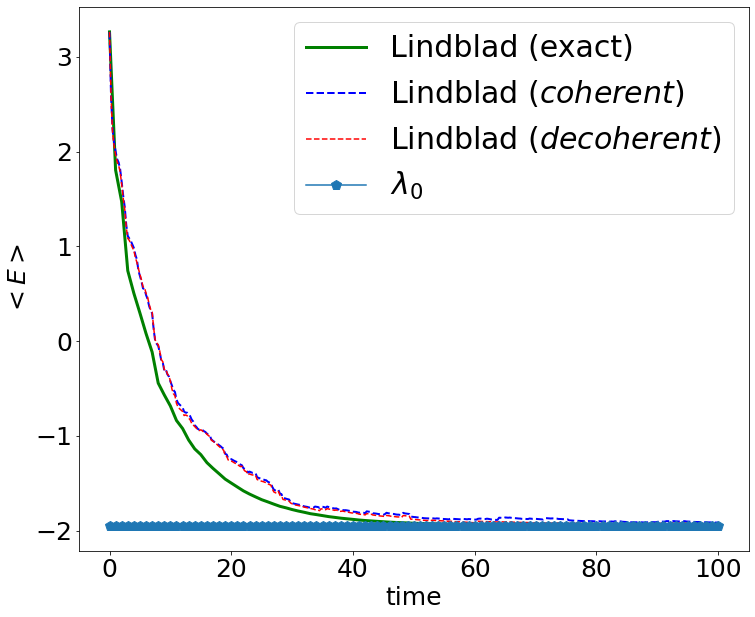

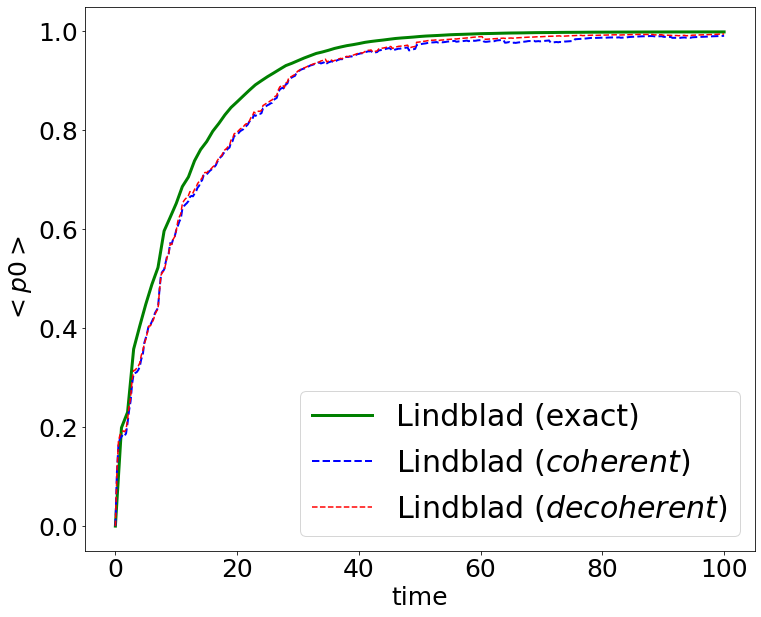

In [4]:
plt.figure(figsize=(12,10))
plt.plot(times, avg_H_e, 'g-', label='Lindblad (exact)', linewidth=3, markersize=10)
plt.plot(times_c, avg_H_c,'b--', label=r'Lindblad $(coherent)$', linewidth=2, markersize=10)
plt.plot(times_l, avg_H_l, 'r--', label=r'Lindblad $(decoherent)$', linewidth=1.5, markersize=10)
plt.plot(times, np.ones_like(times)*E_GS, 'p-', label=r'$\lambda_0$', linewidth=1.5,markersize=10)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<E>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.show()

plt.figure(figsize=(12,10))
plt.plot(times, avg_pGS_e,'g-', label=r'Lindblad (exact)', linewidth=3, markersize=20)
plt.plot(times_c, avg_pGS_c,'b--', label=r'Lindblad $(coherent)$', linewidth=2, markersize=10)
plt.plot(times_l, avg_pGS_l, 'r--', label=r'Lindblad $(decoherent)$', linewidth=1.5, markersize=10)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<p0>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30,loc="lower right")
plt.show()

In [5]:
mode == 'decoherent (small tau)'
num_t = 100*int(T)
num_segment = 1
times_s, avg_H_s, avg_pGS_s, time_H_s, rho_all_s = lb.evolve_kraus_decoherent_batch(T, num_t,
        num_segment, psi0, num_rep, T_kraus, Nt_kraus,
        psi_GS, intorder=2)

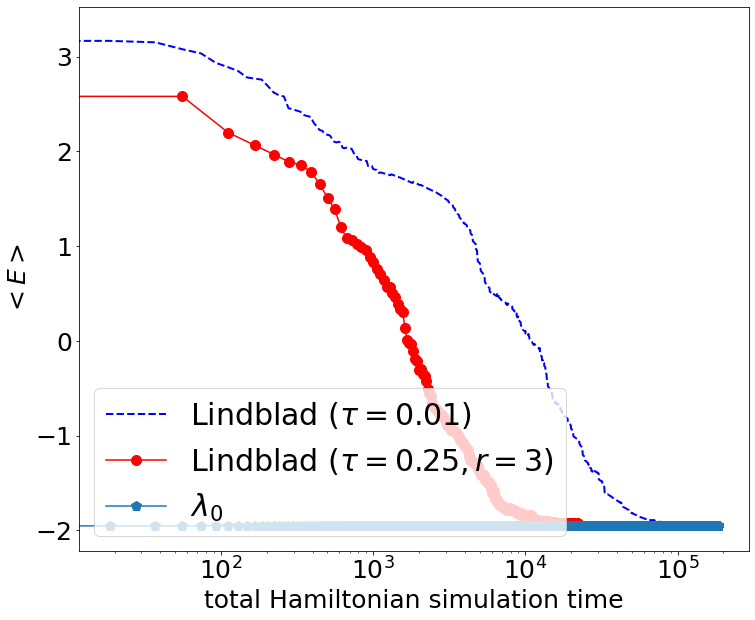

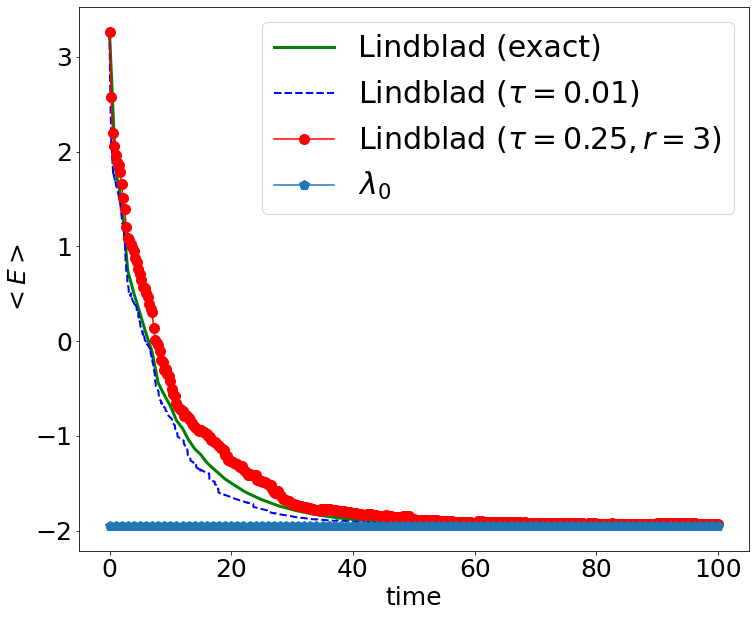

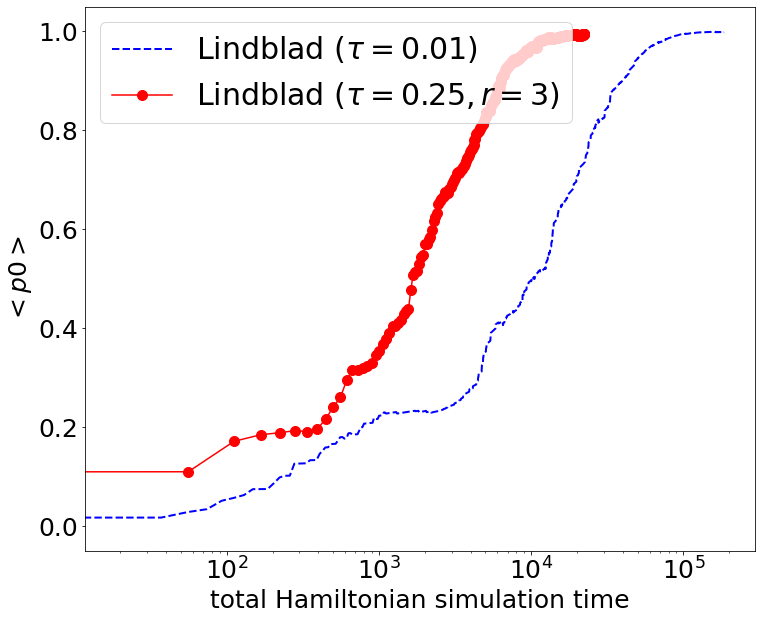

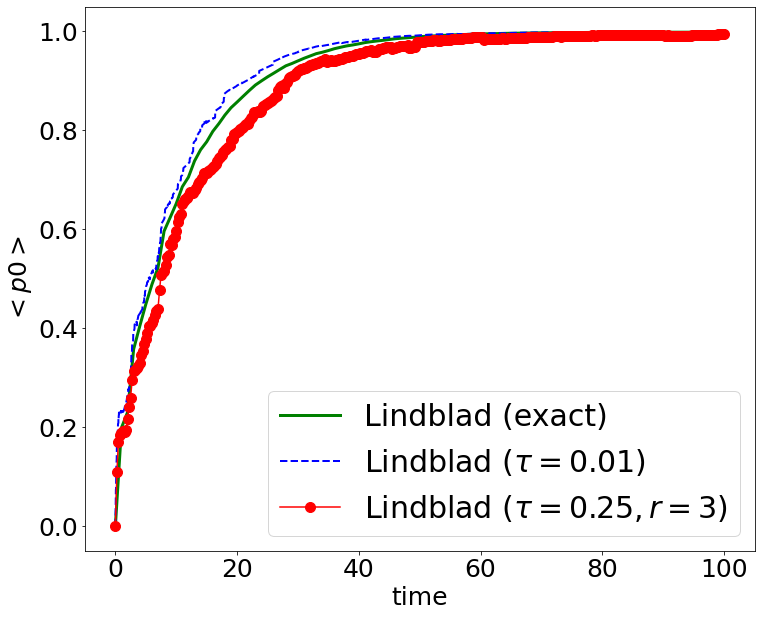

In [6]:
plt.figure(figsize=(12,10))
plt.plot(time_H_s, avg_H_s,'b--', label=r'Lindblad $(\tau=0.01)$', linewidth=2, markersize=10)
plt.plot(time_H_l, avg_H_l, 'r-o', label=r'Lindblad $(\tau=0.25,r=3)$', linewidth=1.5, markersize=10)
plt.plot(time_H_s, np.ones_like(time_H_s)*E_GS, 'p-', label=r'$\lambda_0$', linewidth=1.5,markersize=10)
plt.legend()
plt.xlabel('total Hamiltonian simulation time',fontsize=25)
plt.ylabel(r'$<E>$',fontsize=25)
plt.xscale('log')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30,loc="lower left")
plt.savefig('Hubbard_4_energy_H_time.pdf')
plt.show()

plt.figure(figsize=(12,10))
plt.plot(times, avg_H_e, 'g-', label='Lindblad (exact)', linewidth=3, markersize=10)
plt.plot(times_s, avg_H_s,'b--', label=r'Lindblad $(\tau=0.01)$', linewidth=2, markersize=10)
plt.plot(times_l, avg_H_l, 'r-o', label=r'Lindblad $(\tau=0.25,r=3)$', linewidth=1.5, markersize=10)
plt.plot(times, np.ones_like(times)*E_GS, 'p-', label=r'$\lambda_0$', linewidth=1.5,markersize=10)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<E>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.savefig('Hubbard_4_energy_time.pdf')
plt.show()


plt.figure(figsize=(12,10))
plt.plot(time_H_s, avg_pGS_s,'b--', label=r'Lindblad $(\tau=0.01)$', linewidth=2, markersize=10)
plt.plot(time_H_l, avg_pGS_l, 'r-o', label=r'Lindblad $(\tau=0.25,r=3)$', linewidth=1.5, markersize=10)
plt.legend()
plt.xlabel('total Hamiltonian simulation time',fontsize=25)
plt.ylabel(r'$<p0>$',fontsize=25)
plt.xscale('log')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30,loc="upper left")
plt.savefig('Hubbard_4_overlap_H_time.pdf')
plt.show()

plt.figure(figsize=(12,10))
plt.plot(times, avg_pGS_e,'g-', label=r'Lindblad (exact)', linewidth=3, markersize=20)
plt.plot(times_s, avg_pGS_s,'b--', label=r'Lindblad $(\tau=0.01)$', linewidth=2, markersize=10)
plt.plot(times_l, avg_pGS_l, 'r-o', label=r'Lindblad $(\tau=0.25,r=3)$', linewidth=1.5, markersize=10)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<p0>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30,loc="lower right")
plt.savefig('Hubbard_4_overlap_time.pdf')
plt.show()